# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
unneeded_col = ['PostalCode', 'DateCreated', 'LastSeen', 'DateCrawled', 'NumberOfPictures', 'RegistrationMonth']

In [6]:
data = data.drop(columns=unneeded_col)

Ненужные колонки были удалены

In [7]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

In [8]:
mode_by_brand = data.groupby('Brand')[['VehicleType', 'Gearbox', 'Model', 'FuelType']].\
agg(lambda x: x.mode()[0] if x.count()!=0 else'unknown')
mode_by_brand

,VehicleType,Gearbox,Model,FuelType
Brand,,,,
alfa_romeo,sedan,manual,156,petrol
audi,wagon,manual,a4,petrol
bmw,sedan,manual,3er,petrol
chevrolet,small,manual,other,petrol
chrysler,bus,auto,other,petrol
citroen,small,manual,other,petrol
dacia,wagon,manual,logan,petrol
daewoo,small,manual,matiz,petrol
daihatsu,small,manual,cuore,petrol


In [9]:
for brand in mode_by_brand.index:
    for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType']:
        data.loc[data['Brand']==brand, col] = data.loc[data['Brand']==brand, col].fillna(mode_by_brand.loc[brand, col])

In [10]:
data.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired            71154
dtype: int64

Пропуски в столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType' были заполнены наиболее встречаемыми значениями машин определенных марок

In [11]:
data['Repaired'].fillna('unknown', inplace=True)

In [12]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Пропуски в данных обработаны

In [13]:
data.duplicated().sum()

50211

In [14]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Дубликаты удалены

In [15]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,304158.000000,304158.00000,304158.000000,304158.000000
mean,4535.361440,2004.38481,111.791434,126993.618448
std,4576.741333,93.24838,202.441830,38636.486048
min,0.000000,1000.00000,0.000000,5000.000000
25%,1100.000000,1999.00000,69.000000,125000.000000
50%,2850.000000,2003.00000,105.000000,150000.000000
75%,6500.000000,2008.00000,143.000000,150000.000000
max,20000.000000,9999.00000,20000.000000,150000.000000


In [16]:
def remove_ouliers(frame,column):
    q25 = np.array(frame[column].quantile(0.25))
    q75 = np.array(frame[column].quantile(0.75))
    first_part = q25 - 1.5 * (q75 - q25)
    second_part = q75 + 1.5 * (q75 - q25)
    del_index = []
    for index_value, value in zip(frame[column].index, frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print(f'Количество строк, выбранных для удаления {column} : {len(del_index)}')
    return del_index

In [17]:
for col in ['RegistrationYear', 'Power']:
    index_del = remove_ouliers(data, col)

Количество строк, выбранных для удаления RegistrationYear : 5959
Количество строк, выбранных для удаления Power : 6709


In [18]:
for col in ['RegistrationYear', 'Power']:
    index_del = remove_ouliers(data, col)
    data = data.drop(index_del, axis = 0)

Количество строк, выбранных для удаления RegistrationYear : 5959
Количество строк, выбранных для удаления Power : 6639


In [19]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.475633,0.455115,-0.349551
RegistrationYear,0.475633,1.000000,0.082396,-0.283958
Power,0.455115,0.082396,1.000000,0.090430
Kilometer,-0.349551,-0.283958,0.090430,1.000000


In [20]:
#Код ревьюера
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,291560.000000,291560.000000,291560.000000,291560.000000
mean,4377.042403,2003.708362,104.097846,127542.015366
std,4437.575795,6.480274,56.522387,38047.561006
min,0.000000,1986.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2750.000000,2003.000000,105.000000,150000.000000
75%,6299.000000,2008.000000,140.000000,150000.000000
max,20000.000000,2019.000000,250.000000,150000.000000


[]

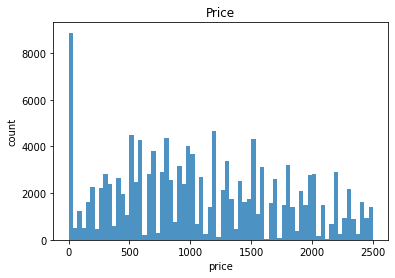

In [21]:
plt.hist(data[data['Price'] < 2500]['Price'], bins=70, alpha=0.8)
plt.title('Price')
plt.xlabel('price')
plt.ylabel('count')
plt.plot()

In [22]:
data = data.drop(data[data['Price'] < 500].index)

[]

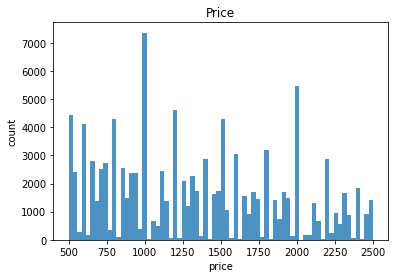

In [23]:
plt.hist(data[data['Price'] < 2500]['Price'], bins=70, alpha=0.8)
plt.title('Price')
plt.xlabel('price')
plt.ylabel('count')
plt.plot()

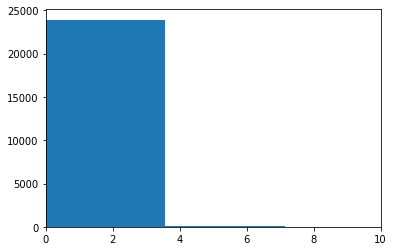

In [24]:
plt.hist(data['Power'], bins=70)
plt.xlim(0,10)
plt.show()

In [25]:
data = data.drop(data[data['Power'] < 10].index)

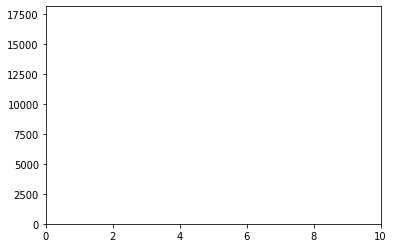

In [26]:
plt.hist(data['Power'], bins=70)
plt.xlim(0,10)
plt.show()

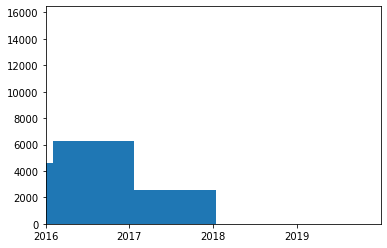

In [27]:
plt.hist(data['RegistrationYear'], bins=len(data['RegistrationYear'].unique()))
plt.xlim(2016, 2020)
plt.xticks(range(2016 ,2020))
plt.show()

In [28]:
data = data.drop(data[data['RegistrationYear'] > 2016].index)

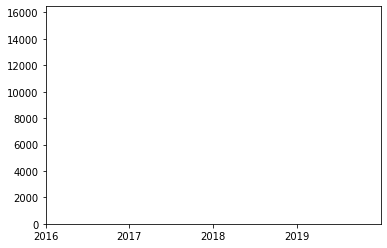

In [29]:
plt.hist(data['RegistrationYear'], bins=len(data['RegistrationYear'].unique()))
plt.xlim(2016, 2020)
plt.xticks(range(2016 ,2020))
plt.show()

Данные полностью обработаны

## Обучение моделей

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229525 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             229525 non-null  int64 
 1   VehicleType       229525 non-null  object
 2   RegistrationYear  229525 non-null  int64 
 3   Gearbox           229525 non-null  object
 4   Power             229525 non-null  int64 
 5   Model             229525 non-null  object
 6   Kilometer         229525 non-null  int64 
 7   FuelType          229525 non-null  object
 8   Brand             229525 non-null  object
 9   Repaired          229525 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.3+ MB


In [31]:
data_ohe = data.copy()
data_ohe = pd.get_dummies(data_ohe)

data_light = data.copy()
data_light = data_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "Repaired":'category'})

In [32]:
(features_train, features_test,
 target_train, target_test) = train_test_split(
    data.drop(columns='Price'),
    data['Price'],
    test_size=0.3,
    random_state=1
)

(features_train_ohe, features_test_ohe,
 target_train_ohe, target_test_ohe) =  train_test_split(
    data_ohe.drop(columns='Price'),
    data_ohe['Price'],
    test_size=0.3,
    random_state=1
)

(features_train_light, features_test_light,
 target_train_light, target_test_light) =  train_test_split(
    data_light.drop(columns='Price'),
    data_light['Price'],
    test_size=0.3,
    random_state=1
)

In [34]:
%%time

model = CatBoostRegressor(loss_function='RMSE', random_seed=1)
params_grid = {'max_depth':range(10,15), 'learning_rate':np.arange(0.1,1,0.2), 'iterations':[200]}

catboost_grid = model.grid_search(params_grid,
            Pool(features_train, target_train,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]),
            cv=3,
            verbose=True,
            plot=False)

0:	learn: 6245.0308029	test: 6219.0640429	best: 6219.0640429 (0)	total: 374ms	remaining: 1m 14s
1:	learn: 5697.5999528	test: 5675.4967669	best: 5675.4967669 (1)	total: 732ms	remaining: 1m 12s
2:	learn: 5214.1357258	test: 5195.6168880	best: 5195.6168880 (2)	total: 1s	remaining: 1m 5s
3:	learn: 4781.8506868	test: 4766.6376599	best: 4766.6376599 (3)	total: 1.31s	remaining: 1m 4s
4:	learn: 4391.7912178	test: 4381.2725514	best: 4381.2725514 (4)	total: 1.63s	remaining: 1m 3s
5:	learn: 4048.5730678	test: 4041.2103206	best: 4041.2103206 (5)	total: 1.93s	remaining: 1m 2s
6:	learn: 3749.1989225	test: 3743.9615307	best: 3743.9615307 (6)	total: 2.17s	remaining: 60s
7:	learn: 3479.2763663	test: 3478.8055873	best: 3478.8055873 (7)	total: 2.4s	remaining: 57.6s
8:	learn: 3244.6127714	test: 3247.8447858	best: 3247.8447858 (8)	total: 2.77s	remaining: 58.7s
9:	learn: 3035.6991376	test: 3042.4165142	best: 3042.4165142 (9)	total: 3.08s	remaining: 58.5s
10:	learn: 2849.5013143	test: 2860.4773207	best: 2860.

In [35]:
catboost_grid["params"]

{'depth': 14, 'iterations': 200, 'learning_rate': 0.1}

In [33]:
def root_mean_squared_error(Y, prediction):
    return mean_squared_error(Y, prediction)**(0.5)

In [34]:
kf = KFold(n_splits=3)
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [35]:
%%time

RF = RandomForestRegressor(criterion = "mse",random_state=42,n_estimators = 100,n_jobs=-1)

CPU times: user 99 µs, sys: 8 µs, total: 107 µs
Wall time: 111 µs


In [36]:
%%time

RF.fit(features_train_ohe, target_train_ohe)

CPU times: user 4min 58s, sys: 1.86 s, total: 5min
Wall time: 5min 1s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [37]:
%%time

prediction_forest = RF.predict(features_train_ohe)

CPU times: user 8.16 s, sys: 168 ms, total: 8.33 s
Wall time: 8.35 s


In [38]:
cross_val_score(RF, features_test_ohe, target_test_ohe, scoring=scorer, cv=kf).mean()

-1688.7878459621636

In [39]:
%%time

lgb_train = lgb.Dataset(features_train_light, target_train_light)
lgb_test = lgb.Dataset(features_train_light, target_train_light, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 1,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_test],
                verbose_eval=100)


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 160667, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 5098.583231
[100]	training's l2: 2.11641e+06	valid_1's l2: 2.11641e+06
[200]	training's l2: 1.98984e+06	valid_1's l2: 1.98984e+06
[300]	training's l2: 1.91458e+06	valid_1's l2: 1.91458e+06
[400]	training's l2: 1.85647e+06	valid_1's l2: 1.85647e+06
[500]	training's l2: 1.81055e+06	valid_1's l2: 1.81055e+06
[600]	training's l2: 1.77011e+06	valid_1's l2: 1.77011e+06
[700]	training's l2: 1.7381e+06	valid_1's l2: 1.7381e+06
[800]	training's l2: 1.70902e+06	valid_1's l2: 1.70902e+06
[900]	training's l2: 1.68107e+06	valid_1's l2: 1.68107e+06
[1000]	training's l2: 1.65812e+06	valid_1's l2: 1.65812e+06
CPU times: user 7min 29s, sys: 9.64 s, total: 7min 38s
Wall time: 7min 42s


In [40]:
%%time

prediction_light = light.predict(features_train_light)

CPU times: user 18.1 s, sys: 59.3 ms, total: 18.1 s
Wall time: 18.4 s


In [41]:
prediction = light.predict(features_test_light)
mean_squared_error(target_test_light, prediction,squared=False)

1467.357371014237

## Анализ моделей

In [42]:
%%time
final_cat = CatBoostRegressor(loss_function='RMSE', random_seed=1, depth=14, iterations=200, learning_rate=0.1)
final_cat.fit(Pool(features_train, target_train, cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]))

0:	learn: 4183.9813327	total: 867ms	remaining: 2m 52s
1:	learn: 3870.0427157	total: 1.66s	remaining: 2m 44s
2:	learn: 3591.8707570	total: 2.33s	remaining: 2m 32s
3:	learn: 3341.2998934	total: 3.1s	remaining: 2m 31s
4:	learn: 3121.7295620	total: 3.81s	remaining: 2m 28s
5:	learn: 2923.3274194	total: 4.58s	remaining: 2m 28s
6:	learn: 2756.5073619	total: 5.33s	remaining: 2m 26s
7:	learn: 2604.8362423	total: 6.07s	remaining: 2m 25s
8:	learn: 2471.5556553	total: 6.8s	remaining: 2m 24s
9:	learn: 2355.0616686	total: 7.63s	remaining: 2m 25s
10:	learn: 2252.7861535	total: 8.29s	remaining: 2m 22s
11:	learn: 2165.4235033	total: 9.05s	remaining: 2m 21s
12:	learn: 2089.7792389	total: 9.76s	remaining: 2m 20s
13:	learn: 2022.5566810	total: 10.5s	remaining: 2m 19s
14:	learn: 1964.9254625	total: 11.1s	remaining: 2m 17s
15:	learn: 1909.8915871	total: 11.8s	remaining: 2m 16s
16:	learn: 1862.2904335	total: 12.4s	remaining: 2m 13s
17:	learn: 1819.3732271	total: 13.1s	remaining: 2m 12s
18:	learn: 1783.860154

In [43]:
%%time
print("CatBoost:", mean_squared_error(target_train, final_cat.predict(features_train),squared=False))

CatBoost: 1313.453388963526
CPU times: user 828 ms, sys: 7.97 ms, total: 836 ms
Wall time: 842 ms


In [43]:
%%time
print("CatBoost:", mean_squared_error(target_test, final_cat.predict(features_test),squared=False))

CatBoost: 1472.4602991965237
CPU times: user 356 ms, sys: 4.51 ms, total: 361 ms
Wall time: 359 ms


## Вывод

Во время выполнения проекты были обработаны данные, а именно были восстановлены пропущенные значения и избавили данные от вбросов.

Учитывая время обучения и предсказания, наилучшим образом себя показала модель, основанная на catboost. Хотя и RMSE LightGBM меньше, но catboost сильно выигрывает по времени.<br>
Гиперпараметры для catboost:(depth=14, iterations=200, learning_rate=0.1)<br>
Время обучения: 171 sec<br>
Время предсказания: 0.8 sec<br>
RMSE: 1472<br>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей